<a href="https://colab.research.google.com/github/realfolkcode/AdversarialRegularization/blob/main/filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import

In [29]:
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [30]:
!git clone https://github.com/realfolkcode/AdversarialRegularization.git

fatal: destination path 'AdversarialRegularization' already exists and is not an empty directory.


# Loading Model

In [31]:
class CNN(nn.Module):
    def __init__(self, num_classes=100):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.features(x)
        x = self.classifier(x)
        return x

In [32]:
model1_path = 'AdversarialRegularization/models/model1_seed0.pt'

model1 = CNN(num_classes=100)
model1.load_state_dict(torch.load(model1_path, map_location=device))

<All keys matched successfully>

In [33]:
model1

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (classifier): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=256, out_features=100, bias=True)
  )
)

# Filter Dataset

Let us create a class for filters dataset to make life easier. We will use it to train discriminators. As input, it would take a list of convolution layers (kernel sizes must be the same).

In [34]:
class FilterDataset(Dataset):
    def __init__(self, layer_lst):
        self.kernels = [layer.weight.data.clone() for layer in layer_lst]
        self.kernels = torch.cat(self.kernels)
        c_out, c_in, h, w = self.kernels.shape
        self.kernels = self.kernels.view(c_out * c_in, -1, h, w)
    
    def __len__(self):
        return len(self.kernels)
    
    def __getitem__(self, idx):
        return self.kernels[idx]

In [35]:
model1.features[0]

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [36]:
filters = FilterDataset([model1.features[0]])
filters_loader = DataLoader(filters, batch_size=32, shuffle=False)

In [37]:
print(f'Dataset size: {len(filters)}')

Dataset size: 192


Now, we can iterate over filters dataset.

In [38]:
for batch in filters_loader:
    print(batch)
    break

tensor([[[[-6.2656e-02,  2.6968e-02, -5.1732e-02,  ...,  1.5943e-02,
            1.9114e-02,  5.2075e-03],
          [ 6.3637e-02, -5.1510e-02, -5.6309e-02,  ..., -5.0091e-02,
           -4.9901e-02,  8.7848e-03],
          [-1.9952e-02,  3.0282e-02,  4.3378e-02,  ..., -7.4231e-02,
           -4.2366e-02,  3.9833e-02],
          ...,
          [-9.9836e-02, -1.9509e-01, -2.9311e-01,  ..., -2.9734e-01,
           -1.5652e-01, -1.0597e-02],
          [ 6.5291e-03,  3.4110e-02,  1.1243e-01,  ...,  1.0632e-02,
            2.7812e-02,  4.4999e-03],
          [ 7.2651e-03, -4.0293e-02, -3.1804e-02,  ...,  7.8343e-02,
            4.1540e-02, -3.4675e-02]]],


        [[[-4.6035e-02,  4.1302e-02,  8.6508e-02,  ...,  1.8882e-02,
            8.5350e-03, -7.6205e-02],
          [ 2.7095e-02, -1.0590e-01, -1.3952e-01,  ..., -3.6123e-02,
            1.2332e-02, -3.9015e-02],
          [ 3.4798e-02,  4.9779e-02, -2.4362e-02,  ..., -4.5231e-02,
           -2.4523e-02,  1.6990e-02],
          ...,
   

We can also visualize kernels to check if our dataset contains patterns.

In [39]:
def plot_kernels(loader, nrow=8):
    dataiter = iter(loader)
    batch = dataiter.next()
    rows = np.min((batch.shape[0] // nrow + 1, 64))    
    grid = torchvision.utils.make_grid(batch, nrow=nrow, normalize=True, padding=1)
    plt.figure(figsize=(nrow,rows))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

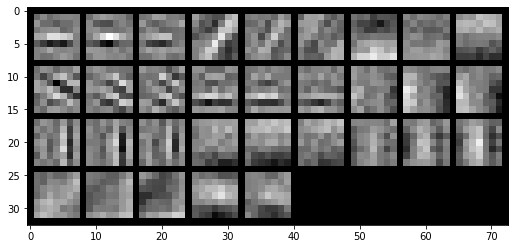

In [40]:
plot_kernels(filters_loader, nrow=9)

Indeed, filters have patterns. Moreover, kernels within the same filter appear to be correlated.

Passing `shuffle=True` to `FilterDataset` results in shuffled batches.

In [41]:
filters_loader = DataLoader(filters, batch_size=32, shuffle=True)

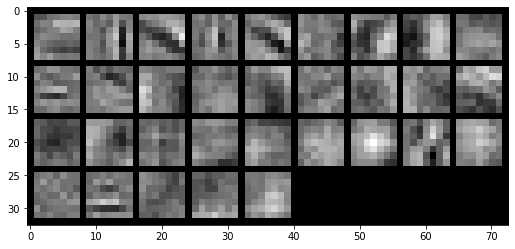

In [42]:
plot_kernels(filters_loader, nrow=9)